In [1]:
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import json

from models import u_net, deeplabv3, fcb_former, fcn, fpn_net, hr_net, link_net
from dataset_loader import ValidationDataset
from solver import Solver

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Visualize the results
def visualize_tensor(image_tensor, mask_tensor, mask_prediction_tensor, metadata):
    """
    Visualize a grayscale image and binary mask from PyTorch tensors.

    Args:
        image_tensor (torch.Tensor): Grayscale image tensor (H x W).
        mask_tensor (torch.Tensor): Binary mask tensor (H x W).
    """
    # Ensure tensors are detached and converted to numpy
    image_np = image_tensor.squeeze(0).numpy()  # Remove the singleton dimension
    mask_np = mask_tensor.squeeze(0).numpy()  # Remove the singleton dimension
    mask_pred_np = mask_prediction_tensor.squeeze(
        0
    ).numpy()  # Remove the singleton dimension

    scan_type = metadata["scan_type"]

    # Convert tensors to PIL images
    image_pil = Image.fromarray((image_np * 255).astype("uint8")).convert(
        "L"
    )  # Scale image to 0-255
    mask_pil = Image.fromarray((mask_np * 255).astype("uint8")).convert(
        "L"
    )  # Binary mask
    mask_pred_pil = Image.fromarray((mask_pred_np * 255).astype("uint8")).convert(
        "L"
    )  # Binary mask prediction

    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))

    # Display scan image on the left
    axes[0].imshow(image_pil, cmap="gray")
    axes[0].set_title(f"MRI (scan: {scan_type}) Image")

    # Display scan image with tumor overlay on the right
    axes[1].imshow(image_pil, cmap="gray", extent=[0, 256, 0, 256])  # Define bounds
    axes[1].imshow(
        mask_pil, cmap="jet", alpha=0.5, extent=[0, 256, 0, 256]
    )  # Match bounds
    axes[1].set_xlim(0, 256)  # Explicitly set x-axis limits
    axes[1].set_ylim(0, 256)  # Explicitly set y-axis limits
    axes[1].set_title(f"MRI (scan: {scan_type}) + Tumor Overlay")

    # Display predicted mask on the right
    axes[2].imshow(image_pil, cmap="gray", extent=[0, 256, 0, 256])  # Define bounds
    axes[2].imshow(
        mask_pred_pil, cmap="jet", alpha=0.5, extent=[0, 256, 0, 256]
    )  # Match bounds
    axes[2].set_xlim(0, 256)  # Explicitly set x-axis limits
    axes[2].set_ylim(0, 256)  # Explicitly set y-axis limits
    axes[2].set_title(f"MRI (scan: {scan_type}) + Predicted Tumor Overlay")

    plt.tight_layout()
    plt.show()

In [4]:
# Visualize the results
def visualize_comparison(
    image_tensor,
    mask,
    mask_pred1,
    mask_pred2,
    mask_pred3,
    name1,
    name2,
    name3,
):
    # Ensure tensors are detached and converted to numpy
    image_np = image_tensor.squeeze(0).numpy()  # Remove the singleton dimension
    mask = mask.squeeze(0).numpy()  # Remove the singleton dimension
    mask_np1 = mask_pred1.squeeze(0).numpy()  # Remove the singleton dimension
    mask_np2 = mask_pred2.squeeze(0).numpy()  # Remove the singleton dimension
    mask_np3 = mask_pred3.squeeze(0).numpy()  # Remove the singleton dimension

    # Convert tensors to PIL images
    image_pil = Image.fromarray((image_np * 255).astype("uint8")).convert(
        "L"
    )  # Scale image to 0-255
    mask_pil = Image.fromarray((mask * 255).astype("uint8")).convert("L")  # Binary mask
    mask_pil1 = Image.fromarray((mask_np1 * 255).astype("uint8")).convert(
        "L"
    )  # Binary mask
    mask_pil2 = Image.fromarray((mask_np2 * 255).astype("uint8")).convert(
        "L"
    )  # Binary mask
    mask_pil3 = Image.fromarray((mask_np3 * 255).astype("uint8")).convert(
        "L"
    )  # Binary mask

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(16, 8))

    # Display scan image with tumor overlay on the right
    axes[0].imshow(image_pil, cmap="gray", extent=[0, 256, 0, 256])  # Define bounds
    axes[0].imshow(
        mask_pil, cmap="jet", alpha=0.5, extent=[0, 256, 0, 256]
    )  # Match bounds
    axes[0].set_xlim(0, 256)  # Explicitly set x-axis limits
    axes[0].set_ylim(0, 256)  # Explicitly set y-axis limits
    axes[0].set_title(f"Ground Truth")

    # Display scan image with tumor overlay on the right
    axes[1].imshow(image_pil, cmap="gray", extent=[0, 256, 0, 256])  # Define bounds
    axes[1].imshow(
        mask_pil1, cmap="jet", alpha=0.5, extent=[0, 256, 0, 256]
    )  # Match bounds
    axes[1].set_xlim(0, 256)  # Explicitly set x-axis limits
    axes[1].set_ylim(0, 256)  # Explicitly set y-axis limits
    axes[1].set_title(f"{name1}")

    # Display scan image with tumor overlay on the right
    axes[2].imshow(image_pil, cmap="gray", extent=[0, 256, 0, 256])  # Define bounds
    axes[2].imshow(
        mask_pil2, cmap="jet", alpha=0.5, extent=[0, 256, 0, 256]
    )  # Match bounds
    axes[2].set_xlim(0, 256)  # Explicitly set x-axis limits
    axes[2].set_ylim(0, 256)  # Explicitly set y-axis limits
    axes[2].set_title(f"{name2}")

    # Display predicted mask on the right
    axes[3].imshow(image_pil, cmap="gray", extent=[0, 256, 0, 256])  # Define bounds
    axes[3].imshow(
        mask_pil3, cmap="jet", alpha=0.5, extent=[0, 256, 0, 256]
    )  # Match bounds
    axes[3].set_xlim(0, 256)  # Explicitly set x-axis limits
    axes[3].set_ylim(0, 256)  # Explicitly set y-axis limits
    axes[3].set_title(f"{name3}")

    plt.tight_layout()
    plt.show()

In [5]:
def plot_history(title, **histories):
    """
    Plot multiple training histories, each in a separate subplot.

    Args:
        title (str): Title for the overall figure.
        histories (dict): Named history lists (e.g., Loss1=[...], Accuracy1=[...]).
    """
    num_plots = len(histories)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots), sharex=True)
    fig.suptitle(title, fontsize=16)

    if num_plots == 1:
        axes = [axes]  # Make it iterable if there's only one plot

    for ax, (label, history) in zip(axes, histories.items()):
        epochs = range(1, len(history) + 1)

        ax.plot(epochs, history, marker="o", linestyle="-", label=label, color="b")

        # Add labels on points
        for x, y in zip(epochs, history):
            ax.text(
                x, y, f"{y:.3f}", ha="center", va="bottom", fontsize=10, color="red"
            )

        ax.set_ylabel("Metric")
        ax.set_title(label)
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel("Epochs")  # Label only the last plot's x-axis
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
    plt.show()

In [6]:
def load_model(model_name):
    if model_name == "u-net":
        model = u_net.UNet(in_channels=1, out_channels=1)
    elif model_name == "deeplabv3":
        model = deeplabv3.Deeplabv3Plus(num_classes=1)
    elif model_name == "fcb-former":
        model = fcb_former.FCBFormer(num_classes=1, in_channels=1)
    elif model_name == "fcn":
        model = fcn.FCN()
    elif model_name == "fpn-net":
        model = fpn_net.FPN(fpn_net.Bottleneck, [2, 2, 2, 2])
    elif model_name == "hr-net":
        model = hr_net.HRNet()
    elif model_name == "link-net":
        model = link_net.LinkNet(n_classes=1)
    else:
        raise ValueError("Invalid model name")
    return model

In [60]:
# Testing model
def load_best_model(name, model_name):
    save_path = f"/scratch/project_2011942/best-models/{name}.pth"
    model = load_model(model_name)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)
    model.eval()
    
    return model

In [13]:
def test(model, name, image, mask):
    mask_pred, dsc, specificity, sensitivity = Solver.test_model(
        model, image, mask, device
    )

    print(name)
    print(f"Unique values in predicted mask: {torch.unique(mask_pred)}")
    print(f"Dice Similarity Coefficient: {dsc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")
    print()

    return mask_pred

In [8]:
# Load results from a JSON file
def load_results(name):
    results_path = f"/scratch/project_2011942/results/{name}.json"
    with open(results_path, "r") as f:
        results = json.load(f)
    return results

In [9]:
# Load validation dataset
test_paths = []
test_path = "/scratch/project_2011942/datasets/test"
test_paths.extend(os.path.join(test_path, path) for path in os.listdir(test_path))

transformation = transforms.Compose(
    [transforms.Resize((256, 256)), transforms.ToTensor()]
)

validation_dataset = ValidationDataset(test_paths, transformation)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Dataset /scratch/project_2011942/datasets/test/UPENN-GBM loaded with 27495 images.
Dataset /scratch/project_2011942/datasets/test/UCSF loaded with 22275 images.
Dataset /scratch/project_2011942/datasets/test/BraTS loaded with 6525 images.
Dataset /scratch/project_2011942/datasets/test/LGG loaded with 795 images.
Loaded 57090 image-mask pairs for validation
Found 23492 image-mask pairs with tumor present and 33598 image-mask pair with tumor not present. Ratio 0.4114906288316693


In [83]:
name1 = "UNetFocalLoss2025-02-05_07-04-45"
name2 = "UNetBCEWithLogitsLoss2025-02-04_01-30-19"
name3 = "UNetAdaptiveDistributionLoss2025-02-05_14-25-07"

model1 = load_best_model(name1, "u-net")
model2 = load_best_model(name2, "u-net")
model3 = load_best_model(name3, "u-net")

results1 = load_results(name1)
results2 = load_results(name2)
results3 = load_results(name3)

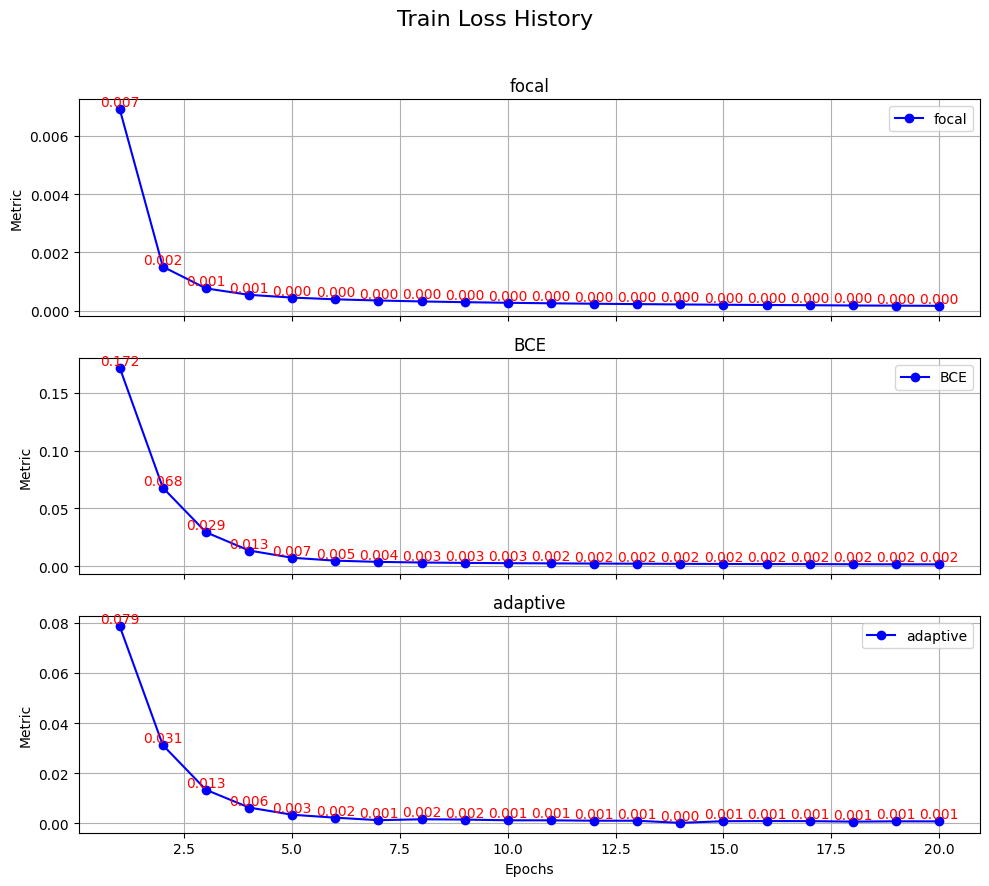

In [84]:
# Print loss history
plot_history(
    "Train Loss History",
    focal=results1["loss_history"],
    BCE=results2["loss_history"],
    adaptive=results3["loss_history"],
)

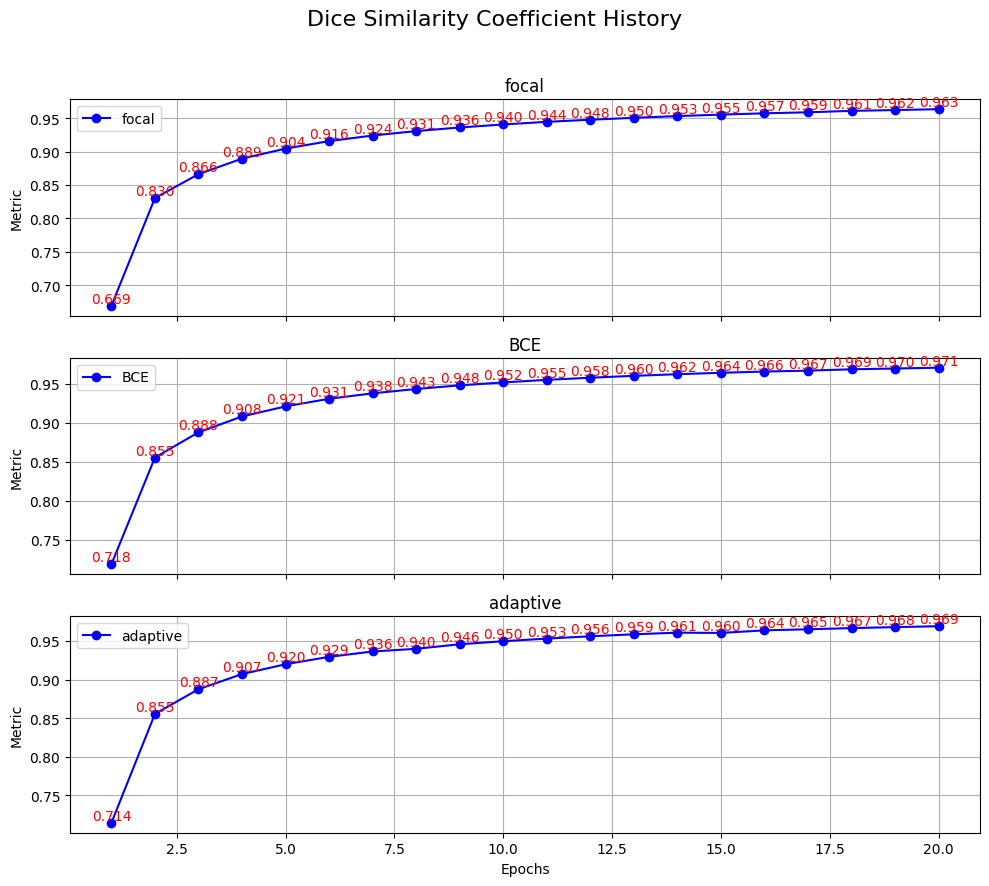

In [85]:
# Print dice similarity coefficient history
plot_history(
    "Dice Similarity Coefficient History",
    focal=results1["dsc_history"],
    BCE=results2["dsc_history"],
    adaptive=results3["dsc_history"],
)

50384
Unique values in mask: tensor([0., 1.])

focal
Unique values in predicted mask: tensor([0., 1.])
Dice Similarity Coefficient: 0.9738878143133463
Specificity: 0.9998265668111943
Sensitivity: 0.9540502131691142

bce
Unique values in predicted mask: tensor([0., 1.])
Dice Similarity Coefficient: 0.9759007396802672
Specificity: 0.9994481671265274
Sensitivity: 0.9687351965892942

adaptive
Unique values in predicted mask: tensor([0., 1.])
Dice Similarity Coefficient: 0.9718952678356955
Specificity: 0.9995427670476942
Sensitivity: 0.9583135954523923



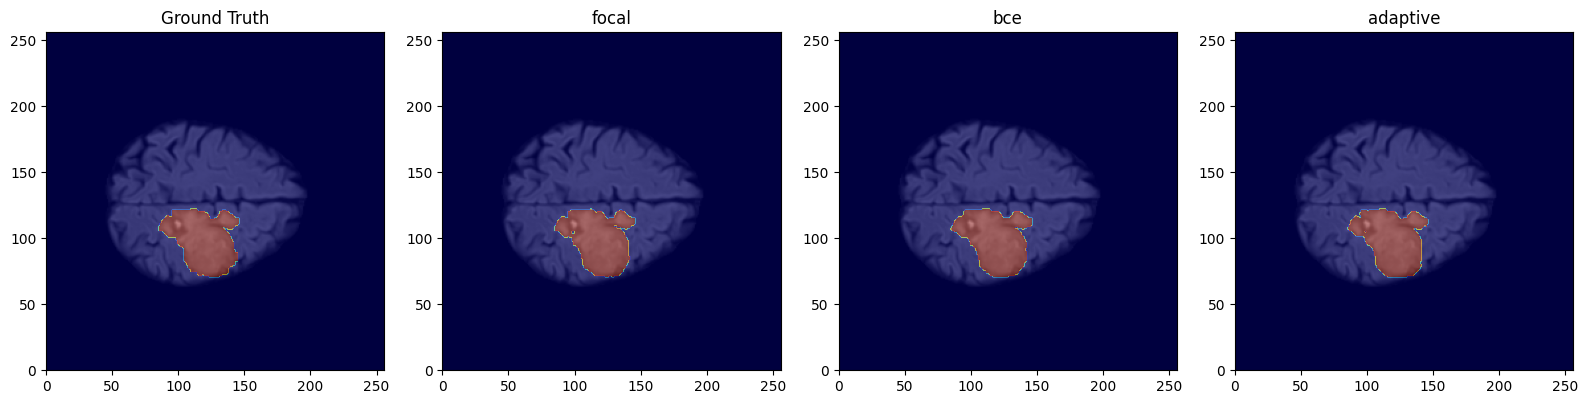

In [129]:
idx = random.randint(0, 57089)
print(idx)

image, mask, metadata = validation_dataset[idx]
#print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Metadata: {metadata}")
print(f"Unique values in mask: {torch.unique(mask)}")
print()


name1 = "focal"
name2 = "bce"
name3 = "adaptive"
pred1 = test(model1, name1, image, mask)
pred2 = test(model2, name2, image, mask)
pred3 = test(model3, name3, image, mask)

visualize_comparison(image, mask, pred1, pred2, pred3, name1, name2, name3)